# Let us first explore the data set for classification

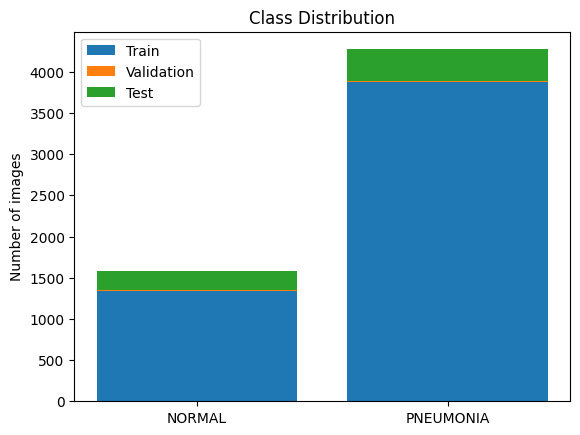

In [1]:
import os
import matplotlib.pyplot as plt

def count_images(directory):
  categories = ['NORMAL', 'PNEUMONIA']
  counts = {}
  for category in categories:
      counts[category] = len(os.listdir(os.path.join(directory, category)))
  return counts

train_counts = count_images('chest_xray/train')
val_counts = count_images('chest_xray/val')
test_counts = count_images('chest_xray/test')

# Plotting
labels = ['NORMAL', 'PNEUMONIA']
x = range(len(labels))
plt.bar(x, [train_counts[label] for label in labels], label='Train')
plt.bar(x, [val_counts[label] for label in labels], bottom=[train_counts[label] for label in labels], label='Validation')
plt.bar(x, [test_counts[label] for label in labels], bottom=[train_counts[label] + val_counts[label] for label in labels], label='Test')
plt.xticks(x, labels)
plt.ylabel('Number of images')
plt.title('Class Distribution')
plt.legend()
plt.show()


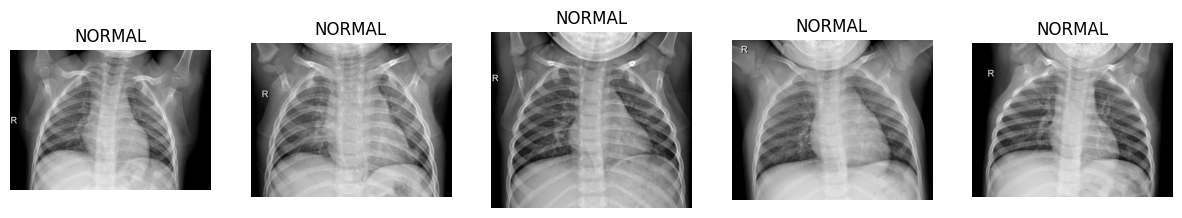

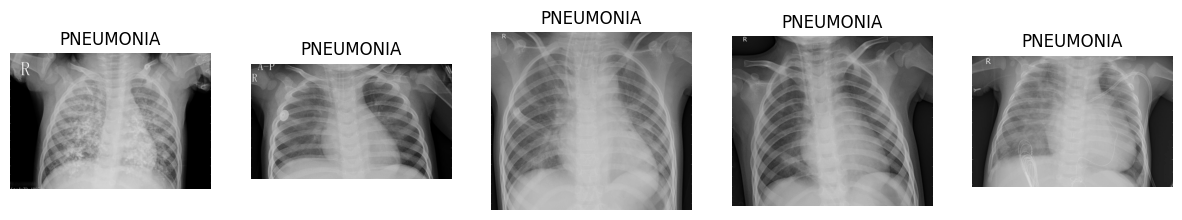

In [2]:
import random
from PIL import Image

def display_samples(directory, category, num_samples=5):
  images = os.listdir(os.path.join(directory, category))
  samples = random.sample(images, num_samples)
  plt.figure(figsize=(15,5))
  for i, img_name in enumerate(samples):
      img_path = os.path.join(directory, category, img_name)
      img = Image.open(img_path)
      plt.subplot(1, num_samples, i+1)
      plt.imshow(img, cmap='gray')
      plt.title(f"{category}")
      plt.axis('off')
  plt.show()

display_samples('chest_xray/train', 'NORMAL')
display_samples('chest_xray/train', 'PNEUMONIA')


# Since we have an unequal split for the dataset lets add class weight while training

## Data Preprocessing
🔹 Image Resizing and Normalization
Objective: Resize images to 224x224 pixels and normalize pixel values.​

Implementation:

In [34]:
!pip show opencv-python-headless

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                 rotation_range=15,
                                 zoom_range=0.1,
                                 horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('chest_xray/train',
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  color_mode='rgb')

val_generator = val_datagen.flow_from_directory('chest_xray/val',
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='binary',
                                              color_mode='rgb')

test_generator = test_datagen.flow_from_directory('chest_xray/test',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='binary',
                                                color_mode='rgb')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


🧠 3. Model Training with MobileNet
🔹 Load Pre-trained MobileNet
Objective: Utilize MobileNet with pre-trained ImageNet weights, excluding the top classification layers.​

Implementation:

In [7]:
from sklearn.utils import class_weight
import numpy as np

# Assuming 'train_generator' is your training data generator
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to a dictionary
class_weights_dict = dict(enumerate(class_weights))


In [8]:
import numpy as np
unique, counts = np.unique(train_generator.classes, return_counts=True)
dict(zip(unique, counts))

{0: 1341, 1: 3875}

In [9]:
class_weights_dict

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Since classes are imbalanced we are giving priority to minority class by introducing the class weight

## Since we want a model which is light weight and can be deployable in the edge we shall go for Mobilenet with pre-trained varient

In [10]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [11]:
from tensorflow.keras import metrics

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)



In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Can also be 'val_precision' or 'val_recall'
    min_delta=0.001,
    patience=3,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

In [13]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5
  8/163 [>.............................] - ETA: 2:37 - loss: 0.5326 - accuracy: 0.7500 - precision: 0.7864 - recall: 0.8901

KeyboardInterrupt: 

In [13]:
# Evaluate the model and store the results
loss, accuracy, precision, recall = model.evaluate(test_generator)

# Print the results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

20/20 [==============================] - 15s 738ms/step - loss: 0.4343 - accuracy: 0.8526 - precision: 0.8117 - recall: 0.9949
Loss: 0.4343
Accuracy: 0.8526
Precision: 0.8117
Recall: 0.9949


20/20 [==============================] - 14s 688ms/step


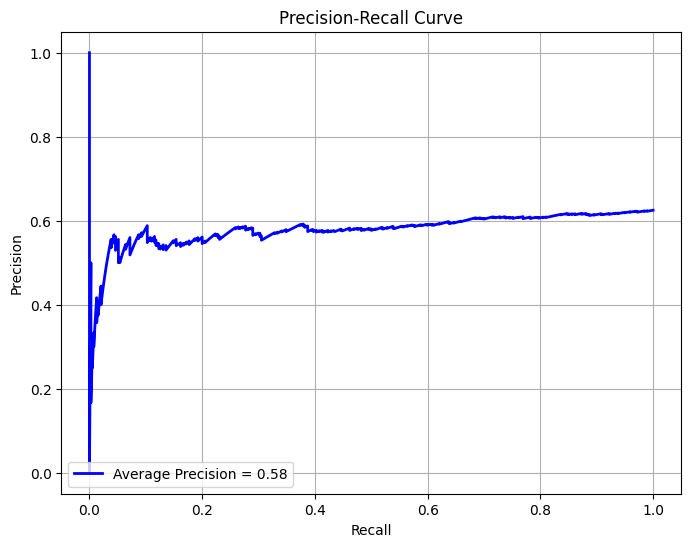

In [14]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# True labels
y_true = test_generator.classes
# Predicted probabilities for the positive class
y_scores = model.predict(test_generator)  # Replace with your predicted scores

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute average precision score
average_precision = average_precision_score(y_true, y_scores)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Obtain true labels
y_true = test_generator.classes

# Predict probabilities
y_pred_probs = model.predict(test_generator)

# Convert probabilities to class labels (assuming binary classification)
y_pred = (y_pred_probs > 0.2).astype(int).flatten()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia'])
print(report)


20/20 [==============================] - 12s 580ms/step
              precision    recall  f1-score   support

      Normal       0.40      0.18      0.25       234
   Pneumonia       0.63      0.83      0.72       390

    accuracy                           0.59       624
   macro avg       0.51      0.51      0.48       624
weighted avg       0.54      0.59      0.54       624



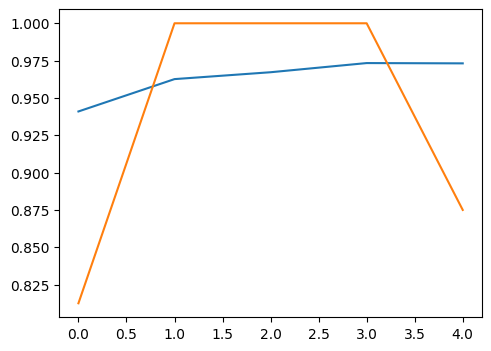

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

 


# # LEt us explain the prediction

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute the gradients of the class output value with respect to the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by the corresponding gradients
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [18]:
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0,1]
    return img_array, img


In [19]:
def display_gradcam(img_path, model, last_conv_layer_name='conv_pw_13_relu'):
    # Preprocess the image
    img_array, original_img = preprocess_image(img_path)

    # Generate the Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Resize heatmap to match the size of the original image
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))

    # Convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(np.array(original_img), 0.6, heatmap, 0.4, 0)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()


In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Path to the image you want to analyze
img_path = r".\chest_xray\test\PNEUMONIA\person99_bacteria_474.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict probabilities
predictions = model.predict(img_array)


1/1 [==============================] - 0s 471ms/step


In [21]:
# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Get predicted probability
probability = predictions[0][0]

# Determine predicted class
predicted_class = class_labels[int(round(probability))]

# Display results
print(f"Predicted Class: {predicted_class}")
print(f"Probability of Pneumonia: {probability:.2f}")
print(f"Probability of Normal: {1 - probability:.2f}")


Predicted Class: Pneumonia
Probability of Pneumonia: 0.95
Probability of Normal: 0.05


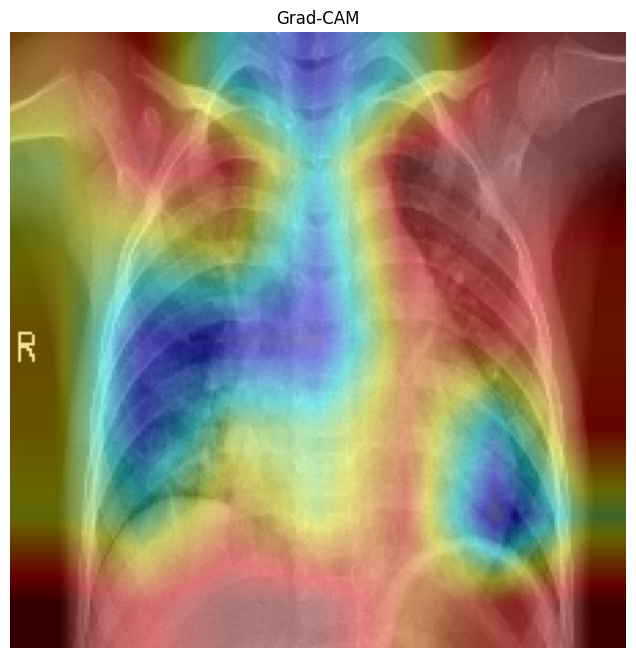

In [22]:
# Path to the image you want to analyze
img_path = r".\chest_xray\test\PNEUMONIA\person99_bacteria_474.jpeg"

# Display the Grad-CAM heatmap
display_gradcam(img_path, model)


In [23]:
model.save('mobilenet_model.h5')


In [24]:
from tensorflow.keras.models import load_model

model = load_model('mobilenet_model.h5')



In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

# Path to the image you want to analyze
img_path = r".\chest_xray\test\PNEUMONIA\person99_bacteria_474.jpeg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict probabilities
predictions = model.predict(img_array)


1/1 [==============================] - 1s 622ms/step


In [26]:
# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Get predicted probability
probability = predictions[0][0]

# Determine predicted class
predicted_class = class_labels[int(round(probability))]

# Display results
print(f"Predicted Class: {predicted_class}")
print(f"Probability of Pneumonia: {probability:.2f}")
print(f"Probability of Normal: {1 - probability:.2f}")


Predicted Class: Pneumonia
Probability of Pneumonia: 0.95
Probability of Normal: 0.05


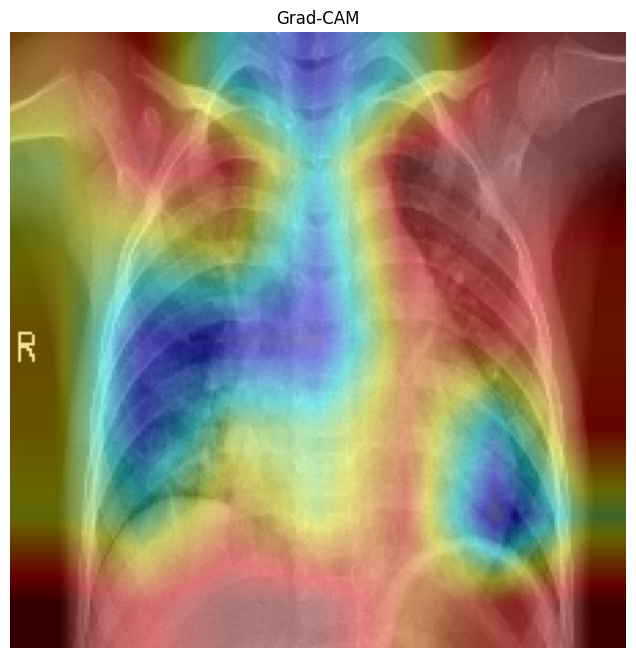

In [27]:
# Path to the image you want to analyze
img_path = r".\chest_xray\test\PNEUMONIA\person99_bacteria_474.jpeg"

# Display the Grad-CAM heatmap
display_gradcam(img_path, model)


In [3]:
import tensorflow as tf

# Load the model
model = load_model('mobilenet_model.keras')

# Convert the model to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Apply quantization
tflite_model = converter.convert()

# Save the quantized TFLite model
with open('mobilenet_model_quantized.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\GOWTHA~1.BAL\AppData\Local\Temp\tmphud5utw3\assets


INFO:tensorflow:Assets written to: C:\Users\GOWTHA~1.BAL\AppData\Local\Temp\tmphud5utw3\assets


In [8]:
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="mobilenet_model_quantized.tflite")

# Allocate tensors (important before running inference)
interpreter.allocate_tensors()


In [6]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\gowtham.balachan\Downloads\Xray classification\XRayClassification\chest_xray\train\NORMAL\NORMAL2-IM-1406-0001.jpeg"
img = image.load_img(img_path, target_size=(224, 224))  # Ensure it matches the input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize if necessary


In [9]:
# Get input details (input tensor index and shape)
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

# Set the input tensor (input tensor must have the shape (1, 224, 224, 3) for MobileNet)
interpreter.set_tensor(input_index, img_array)


In [10]:
# Run inference
interpreter.invoke()

# Get output details (output tensor index and shape)
output_details = interpreter.get_output_details()
output_index = output_details[0]['index']

# Get the output
output = interpreter.get_tensor(output_index)


In [13]:
# If it's a classification task, you can find the index with the highest probability
# Define class labels
class_labels = ['Normal', 'Pneumonia']
predicted_class = class_labels[np.argmax(output)]
print(f"Predicted class index: {predicted_class}")


Predicted class index: Normal
